In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from collections import Counter


In [26]:
with open("data/training/text8_20m.txt") as f:
    text= f.read()
    
text[:100]

'anarchism originated as a term of abuse first used against early working class radicals including th'

**Text Preprocessing** 


In [27]:
words= text.split(" ")

words[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

**Building the Vocabulary**

In [28]:
words_count= Counter(words).most_common(60000)

most_freq_words= [item for item, _ in words_count]

#assigning unique id to every word
word_idx= {word: i+1 for i, word in enumerate(most_freq_words)}
word_idx['<UNK>']= 0

#converting text to idx
text_idx= [word_idx.get(w, word_idx['<UNK>']) for w in words]

#add freq of unfrequent words
words_count.append(('UNK', text_idx.count(0)))

text_idx[:10]

[1336, 2862, 13, 7, 194, 2, 4067, 49, 60, 137]

**Generate training data**

In [29]:
def generate_training_pairs(words, C):
    training_pairs= []
    n= len(words)
    
    for i, center_word in enumerate(text_idx):
        start_idx= max(0, i-C)
        end_idx= min(n-1, i+C+1)
        
        for j in range(start_idx, end_idx):
            if j!=i: #skip center word
                training_pairs.append((center_word, words[j]))
    
    return training_pairs

C= 2

training_pairs= generate_training_pairs(text_idx, C)

training_pairs[:10]

[(1336, 2862),
 (1336, 13),
 (2862, 1336),
 (2862, 13),
 (2862, 7),
 (13, 1336),
 (13, 2862),
 (13, 7),
 (13, 194),
 (7, 2862)]

Calculate unigram and smoothed unigram distribution

In [30]:
import numpy as np
N= sum([c for _,c in words_count])
alpha= 3/4

unigram= {word: freq/N for word,freq in words_count}

unigram_sum= sum(u**alpha for u in unigram.values())

smoothed_unigram= {word: (uni**alpha)/unigram_sum for word, uni in unigram.items()}

unigram_table= np.array(list(smoothed_unigram.values()))


**Training Loop**

In [31]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from Skipgram import Skipgram
from NegativeSamplingLoss import NegativeSamplingLoss
import torch
import numpy as np

def train_skipgram(dataset, vocab_size, unigram, embedding_dim, batch_size=64, epochs=5, learning_rate=0.01, num_negatives=20):
    
    dataloader= DataLoader(dataset, batch_size)
    
    model= Skipgram(vocab_size, embedding_dim)
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model= model.to(device)
    
    criterion= NegativeSamplingLoss()
    optim= Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        total_loss= 0
        
        for center, contexts in dataloader:
            center, contexts = center.long(), contexts.long()
            center= center.to(device)
            contexts= contexts.to(device)
            
            #make sure batch_size is equal
            current_batch_size= len(center)
            
            #sample negatives from unigram
            negatives= torch.tensor(
                np.random.choice(
                    vocab_size,
                    (current_batch_size, num_negatives),
                    p= unigram
                ),
                dtype=torch.long
            )
            negatives= negatives.to(device)
            
            #forward pass
            positive_score, negative_score= model(center, contexts, negatives)
            
            loss= criterion(positive_score, negative_score)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            total_loss+= loss.item()
            
        print(f"Epoch {epoch+1}/{epochs} -- Loss: {total_loss/len(dataloader):.4F}")
    
    return model
            

**Training**

In [ ]:
from SkipgramDataset import SkipgramDataset
import time

### Hyperparameters ###
EMBEDDING_DIM= 128
BATCH_SIZE= 128
EPOCHS= 5
LEARNIN_RATE= 0.01
NUM_NEGATIVES= 10
#######################

pairs= training_pairs
dataset= SkipgramDataset(pairs)
vocab_size= 60001

embedding_dim= 128

t0= time.time()
model = train_skipgram(dataset, vocab_size, unigram_table,
                       embedding_dim= EMBEDDING_DIM,
                       batch_size= BATCH_SIZE,
                       epochs= EPOCHS,
                       learning_rate=LEARNIN_RATE,
                       num_negatives=NUM_NEGATIVES)
t1= time.time()

torch.save(model.state_dict(), 'model.pth')

print(f"Time: {t1-t0:.2F} seconds")


Epoch 1/5 -- Loss: 5.5296
Epoch 2/5 -- Loss: 1.6609
Epoch 3/5 -- Loss: 0.7316
Epoch 4/5 -- Loss: 0.4436
Epoch 5/5 -- Loss: 0.3007
Time: 13.75 seconds


**Evaluation**

Calculate word embeddings for the evaluation words.

In [15]:
import pandas as pd

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = Skipgram(vocab_size, embedding_dim) # Reinitialize the model
model.to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

wordsim353_df= pd.read_csv("data/evaluation/wordsim353.csv")

w1_embedding= wordsim353_df["W1 Embeddning"]= [model.embedding(torch.tensor(word_idx.get(w1)).to(device)).cpu().detach().numpy() if w1 in word_idx.keys() else None
                                 for w1 in wordsim353_df['Word 1']]

w2_embedding= wordsim353_df["W2 Embeddning"]= [model.embedding(torch.tensor(word_idx.get(w2)).to(device)).cpu().detach().numpy() if w2 in word_idx.keys() else None
                                 for w2 in wordsim353_df['Word 2']]

wordsim353_df['Cosine similarity']= [np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    if v1 is not None and v2 is not None else None
    for v1, v2 in zip(w1_embedding, w2_embedding)]

wordsim353_df=wordsim353_df.dropna(axis=0)

wordsim353_df.head()

,Word 1,Word 2,Human (mean),W1 Embeddning,W2 Embeddning,Cosine similarity
0,love,sex,6.77,"[0.2262817, 0.22028634, -0.22704808, 0.2233937...","[0.3106268, 0.3070687, -0.31160784, 0.29613394...",0.999499
1,tiger,cat,7.35,"[-0.0037507408, -0.0059928163, -0.004500053, 0...","[0.1954609, 0.2084196, -0.19870444, 0.20429687...",0.061317
2,tiger,tiger,10.00,"[-0.0037507408, -0.0059928163, -0.004500053, 0...","[-0.0037507408, -0.0059928163, -0.004500053, 0...",1.000000
3,book,paper,7.46,"[0.28795138, 0.2615544, -0.28298697, 0.3228428...","[0.21071155, 0.21330245, -0.20778066, 0.222949...",0.997360
4,computer,keyboard,7.62,"[-0.006955509, 0.001984325, -0.0067205187, 0.0...","[-0.007703325, -0.0009546049, 0.009690176, -0....",-0.035870


Compare inferred cosine similarity and human-assigned similarity using Spearman’s rank correlation coefficient.

In [16]:
from scipy.stats import spearmanr

cosine_sim= np.array(wordsim353_df['Cosine similarity'])
human_score= np.array(wordsim353_df['Human (mean)'])

spearman_coef= spearmanr(cosine_sim, wordsim353_df['Human (mean)'])

spearman_coef

SignificanceResult(statistic=-0.010213991892217512, pvalue=0.8549070744549372)

**Visualization**

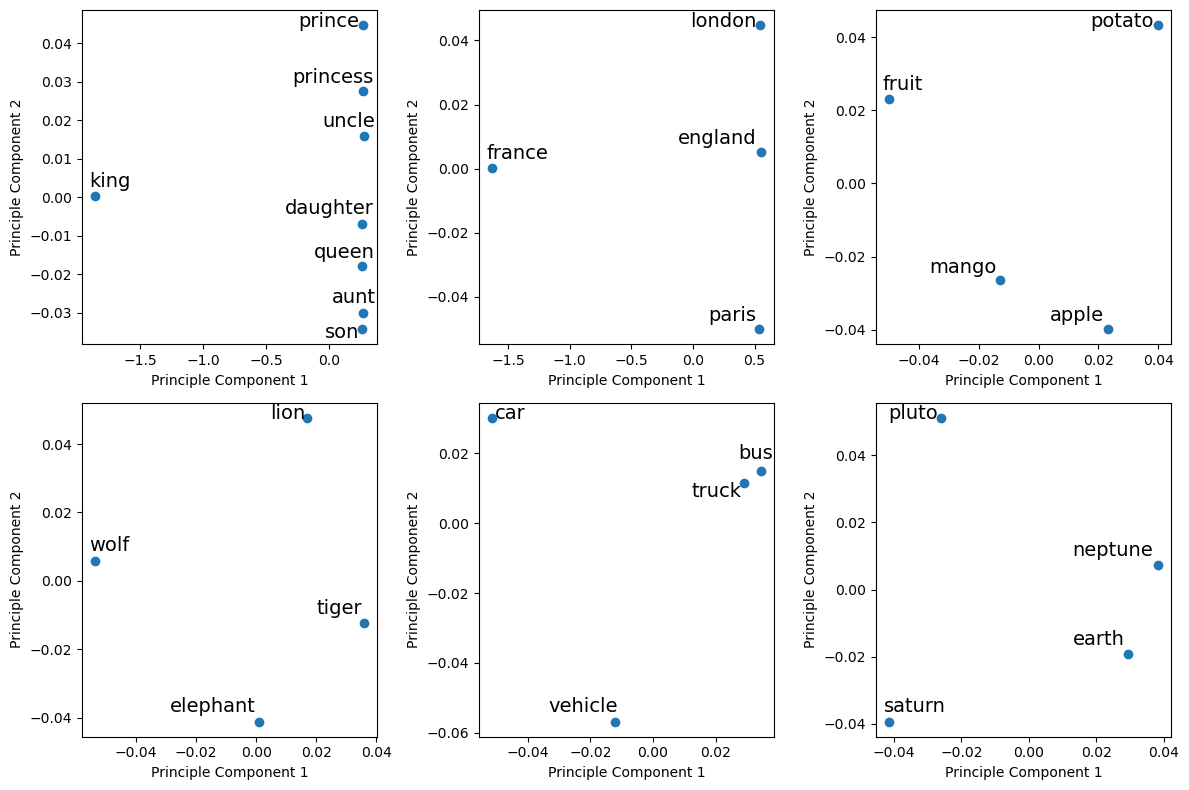

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from adjustText import adjust_text

def visualize_reduced_embeddings(embeddings, labels):


    # Create a figure and a set of subplots
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    axes = axes.flatten()

    # Plot each group of points in a separate subplot
    for i, (group, ax) in enumerate(zip(embeddings, axes)):
        x_coords, y_coords = zip(*group) 
        scatter = ax.scatter(x_coords, y_coords)
        
        texts = []
        for j, label in enumerate(labels[i]):
            text = ax.annotate(label, (x_coords[j], y_coords[j]), fontsize=14, color='black', ha='right')
            texts.append(text)  # Add each annotation to the texts list
        
        # Adjust the annotations to prevent overlap
        adjust_text(texts, ax=ax, only_move={'points': 'y', 'texts': 'xy'}, expand_points=(1.05, 1.05))

            
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')        

    plt.tight_layout()
    
    plt.show()


eval_words = [
    ["king", "queen", "prince", "princess", "aunt", "uncle", "daughter", "son"],
    ["paris", "france", "london", "england"],
    ["apple", "potato", "mango", "fruit"],
    ["lion", "wolf", "tiger", "elephant"],
    ["car", "truck", "vehicle", "bus"],
    ["neptune", "saturn", "pluto", "earth"]
]

eval_words_embeddings= [
    [model.embedding(torch.tensor(word_idx.get(w)).to(device)).cpu().detach().numpy()
                                 for w in l ] 
    for l in eval_words
]

pca= PCA(n_components=2)

reduced_embeddings= [pca.fit_transform(l) for l in eval_words_embeddings]
visualize_reduced_embeddings(reduced_embeddings, eval_words)